In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

import phyre
random.seed(0)

In [45]:
print('All eval setups:', *phyre.MAIN_EVAL_SETUPS)
eval_setup = 'two_balls_cross_template'

All eval setups: ball_cross_template ball_within_template two_balls_cross_template two_balls_within_template ball_phyre_to_tools


In [46]:
fold_id = 0  # For simplicity, we will just use one fold for evaluation.
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits:\n train:', len(train_tasks), '\n dev:',
      len(dev_tasks), '\n test:', len(test_tasks))

Size of resulting splits:
 train: 2000 
 dev: 600 
 test: 600


In [47]:
train_tasks[120]

'00001:020'

In [48]:
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_phyre_to_tools is ball


In [49]:
tasks = dev_tasks[:400]

# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

Initial scene shape=(256, 256) dtype=int64


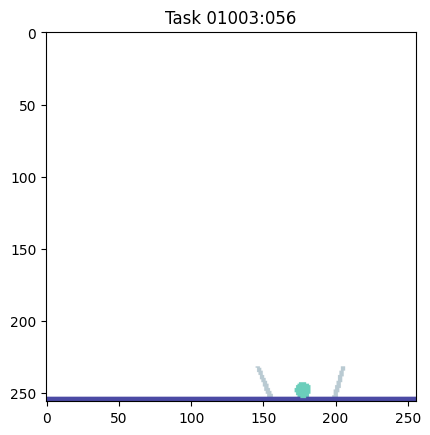

In [50]:
task_index = 121  # Note, this is a integer index of task within simulator.task_ids.
task_id = simulator.task_ids[task_index]
initial_scene = simulator.initial_scenes[task_index]
print('Initial scene shape=%s dtype=%s' % (initial_scene.shape, initial_scene.dtype))
plt.imshow(phyre.observations_to_float_rgb(initial_scene))
plt.title(f'Task {task_id}');

### Initial Vectorized Objects
In addition to the pixelized initial scenes, one can also get access to a vectorized state of each scene object in it's initial posiition. Each task is represented as a FeaturizedObjects, which contains features represented as a 1 x (NUM_SCENE_OBJECTS + TASK_TIER_NUM_USER_INPUTS) x 14 np.ndarray. The features of the object, in order are:

0. x in pixels of center of mass divided by SCENE_WIDTH
1. y in pixels of center of mass divided by SCENE_HEIGHT
2. angle of the object between 0 and 2pi divided by 2pi
3. diameter in pixels of object divided by SCENE_WIDTH
4. - 8. One hot encoding of the object shape, according to order: ball, bar, jar, standing sticks
9. - 14. One hot encoding of object color, according to order: red, green, blue, purple, gray, black
As the scene is vectorized into prior to user input, the rows represent only scene objects.

In [51]:
# Let's see the features of the initial featurized objects for the scene visualized above
initial_featurized_objects = simulator.initial_featurized_objects[task_index]
print('Initial featurized objects shape=%s dtype=%s' % (initial_featurized_objects.features.shape, initial_featurized_objects.features.dtype))
np.set_printoptions(precision=3)
print(initial_featurized_objects.features)

Initial featurized objects shape=(1, 1, 14) dtype=float32
[[[0.695 0.03  0.    0.043 1.    0.    0.    0.    0.    1.    0.
   0.    0.    0.   ]]]


The action space is always a unit cube, but the dimension depends on the action tier. For the ball tier, the dimensionality of the action space is 3, corresponding to the (x,y) position of the ball and its radius r. For two ball tiers the dimension is 6.

In [52]:
print('Dimension of the action space:', simulator.action_space_dim)
# We can also use the simulator to sample a fixed set of random actions from the action space using build_discrete_action_space. The function samples actions uniformly from the action cube skipping invalid ones. The set is guaranteed to be deterministic.
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])

Dimension of the action space: 3
A random action: [4.170e-01 7.203e-01 1.144e-04]


In [53]:
task_index = 121  # The simulator takes an index into simulator.task_ids.
action = random.choice(actions)
# Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True, stride=3)

# Three statuses could be returned.
print('Action solves task:', phyre.SimulationStatus.SOLVED)
print('Action does not solve task:', phyre.SimulationStatus.NOT_SOLVED)
print('Action is an invalid input on task (e.g., occludes a task object):',
      phyre.SimulationStatus.INVALID_INPUT)
# May call is_* methods on the status to check the status.
print()
print('Result of taking action', action, 'on task', tasks[task_index], 'is:',
      simulation.status)
print('Does', action, 'solve task', tasks[task_index], '?', simulation.status.is_solved())
print('Is', action, 'an invalid action on task', tasks[task_index], '?',
      simulation.status.is_invalid())

Action solves task: SimulationStatus.SOLVED
Action does not solve task: SimulationStatus.NOT_SOLVED
Action is an invalid input on task (e.g., occludes a task object): SimulationStatus.INVALID_INPUT

Result of taking action [0.67  0.417 0.559] on task 01003:056 is: SimulationStatus.NOT_SOLVED
Does [0.67  0.417 0.559] solve task 01003:056 ? False
Is [0.67  0.417 0.559] an invalid action on task 01003:056 ? False


In [54]:
print('Number of observations returned by simulator:', len(simulation.images))
print('default stride: ', phyre.simulator.DEFAULT_STRIDE)
print('default max steps: ', phyre.simulator.DEFAULT_MAX_STEPS)

Number of observations returned by simulator: 334
default stride:  60
default max steps:  1000


In [55]:
phyre.observations_to_uint8_rgb(simulation.images[1])

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164],
        ...,
        [ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164]],

       [[ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164],
        ...,
        [ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164]],

       [[ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164],
        ...,
        [ 75,  74, 164],
        [ 75,  74, 164],
        [ 75,  74, 164]]

In [56]:
import imageio
import copy
prev_image:np.array = copy.deepcopy(simulation.images[0])
frames:list = [phyre.observations_to_uint8_rgb(simulation.images[0])]
MAX_SAME_FRAME = 5
same_frame = 0

for i, image in enumerate(simulation.images[1:]):
    if np.absolute(image - prev_image).sum() < 0.1:
        same_frame += 1
        if same_frame > MAX_SAME_FRAME:
            break
    else:
        same_frame = 0
    prev_image = copy.deepcopy(image)
    frames.append(phyre.observations_to_uint8_rgb(image))
frames = np.stack(frames, axis=0)
print(f"total frames after processing: {frames.shape[0]}")

total frames after processing: 267


In [57]:
imageio.mimwrite('temp_video.mp4', frames, fps=20)